# Introduction
Parameter estimation is a common data analysis problem. We can think of many *real life* examples of experiments where we are interested in knowing the value of a set of parameters, e.g., the charge of the electron, the mass of the Moon, etc. In this notebook we focus on examples where we are interested in estimating the value of a single parameter. These examples will be used to discuss about the use of Bayes' Theorem, error-bars, and confidence intervals.

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Example 1: Fair coin?
Assume that we encounter a very *strange* coin. This is, we observe that from 11 flips only 4 of them landed heads. Naturally we can ask: is this a fair coin?
Where by fair we mean a coin that has $1/2$ chances of landing heads/tails on a flip.

Moreover, let's say we determine the coin is fair. How sure are we of our assertion about the coin? IF the coin was not fair, how unfair do we think the coin is?

To try answering these questions we need to formulate the problem more precisely. Instead of considering a pair of hypothesis (the coin is fair or not) we can see the problem through a large number of contiguous propositions, or hypothesis, about the range in which the *bias-weighting* of the coin might lie. Let $H$ denote this *bias-weighting*, then if $H=0$ the coin will always land tails after a flip. Conversely, when $H=1$ the coin will always land heads after a flip. Notice that $H=1/2$ indicates a **fair coin**.

The propositions then could be stated in the form: 
* $0.00 < H < 0.01$;
* $0.01 < H < 0.02$;
* $0.03 < H < 0.03$;
* so on...

In this way, the *state of knowledge* about the (degree of) fairness or unfairness of the coin is specified by how much we believe the statement to be true, given by the probability assigned to each of the propositions or to groups of them. 

In the presence of data, our inference about the fairness of the coin is summarized by the contditional pdf: $$\text{prob}(H| \text{\{data\}}, I),$$ where the probability that $H$ lies within an infinitesimal interval $dH$ is given by:
$$\text{prob}(H| \text{\{data\}}, I)dH.$$
To estimate this posterior pdf we need to use Bayes' Theorem:
$$\text{prob}(X | Y,I) = \dfrac{\text{prob}(Y | X, I)\times\text{prob}(Y | I)}{\text{prob}(Y | I)}.$$

Which in our case reads:
$$\text{prob}(H | \text{\{data\}},I) \propto \text{prob}(\text{\{data\}}| H,I)\times \text{prob}(H | I),$$

note that we have omitted $\text{prob}(\text{\{data\}}, I)$ since does not involve $H$. If needed, we can calculate the normalization factor from:
$$\int_{0}^{1}\text{prob}(H | \text{\{data\}}, I)dH = 1.$$

The prior pdf, $\text{prob}(H | I)$ represents our knowledge about the coin given the information we have about the problem: *a strange coin*. We can assign a simple probability that reflects this situation, for instance:
$$\text{prob}(H|I) = \left\{ \begin{array}\\ 1, \,\, 0 \leq H \leq 1 \\
                                0, \text{ otherwise}\end{array}\right.$$
                                
This prior state of knowledge will be updated by data via the likelihood function: $\text{prob}(\text{\{data\}}| H, I)$. Additionally, we can assume the coin tosses are independent events, then the probability of getting **R heads in N tosses** is given by the binomial distribution:

$$\text{prob}(\text{\{data\}}| H, I) \propto H^R(1-H)^{N-R}.$$

Don't worry about the origin of this expression for the moment, we will come back to it on future notebooks. However, we can intuitively see that it seems reasonable. First, $H$ stands for the *bias-weighting* of the coin and can be interpreted as the probability of the coin landing heads after a toss. We observed $R$ such events. Conversely, $(1-H)$ is the probability of the coin landing tails after a toss and there were $(N-R)$ observed events.

According to the Bayes' Theorem we just need to multiply the two last above quantities to obtain the posterior pdf we are after for. To see this we will look at how the prior pdf changes in the light of data about the coin.

## Simulating the coin tosses
First we need an object that simulates the coin tosses with a given **bias weighting** value $H$. In this case this amounts to getting data from a binomial distribution whose pdf is given by: 
$$\text{prob}(R) = \left(\begin{array}\\N\\R\end{array}\right)H^R(1-H)^{N-R},$$

this is, the probability of getting $R$ successes (coin landing heads) after $N$ Bernoulli trials.

Let us set $ H = 0.3$ to simulate a very biased coin.The experiment will consist in drawing a series of Bernoulli events, for that we use numpy's `random.binomial`, where an output of $0$ represents the coin landing tails and $1$ for heads. 

So, we simulate the toss of a single coin a hundred times, the results of the simulation are stored on a list:

In [118]:
np.random.seed(42)
H = 0.3
N = 1000

# Run the experiment:
experiment = np.random.binomial(1, H, size = N)

We need a function that calculates the pdf (likelihood) given the observation. This function must be able to store the state of pdf previous to the new observation.

In [143]:
class BinomialPDF:
    def __init__(self, state = None, step = None):
        ''' init method of the class
        Parameters:
        -----------
        state: list [k, n-k], where k is the number of successes and n the total 
                               total number of observations.
        step: int, counter for the number of observations the BinomialPDF has already seen
        '''
        self.state = state
        self.step = step
        if self.state == None:
            self.state = [0,0]
        if self.step == None:
            self.step = 0
        self.binom = 1

    
    def update(self, datum):
        '''update the binomial pdf with an observation.
        Parameters:
        -----------
        datum: int (0 or 1), outcome of a Bernoulli event
        
        Returns: 
        -------
        state: tuple, updated state of the binomial distribution (k, n-k)
        '''
        self.step += 1
        self.state[0] += datum
        self.state[1] += 1 - datum
        self.binom = self.binomial_coef()
#         print(f'k = {self.state[0]} n-k = {self.state[1]}, binomial coefficient: {self.binom}')
#         print(f'Updated BinomialPDF with observation {datum}')
        
        
    def binomial_coef(self):
        try:
            coef = np.divide(np.math.factorial(self.state[1]), 
                         np.math.factorial(self.state[0])*np.math.factorial(self.state[1] - self.state[0]))
        except ValueError:
            coef = 1
        return coef
    
    def generate_pdf_points(self, n_points = 1000):
        '''Generates the arrays necessary to plot the Binomial distribution for 
            all values of the probability of success.
        Parameters:
        -----------
        n_points: int, number of points to be generated
        
        Returns:
        --------
        pdf: tuple (prob of success values, pdf values) containing the x and y values, 
        '''
        x = np.arange(0,1, 1/n_points)
        y = self.binom*np.multiply(x**self.state[0], (1-x)**self.state[1])
        return (x,y)

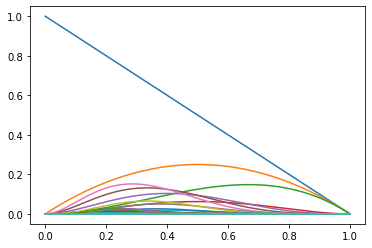

In [153]:
pdf = BinomialPDF()
for datum in experiment:
    pdf.update(datum)
    plt.plot(*pdf.generate_pdf_points())


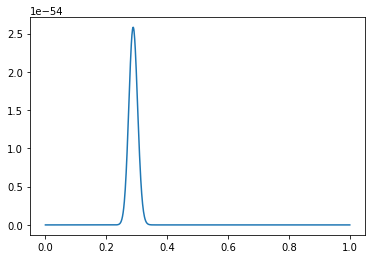

In [151]:
plt.plot(*pdf.generate_pdf_points())

In [74]:
experiment[0]

0

/usr/local/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  This is separate from the ipykernel package so we can avoid doing imports until


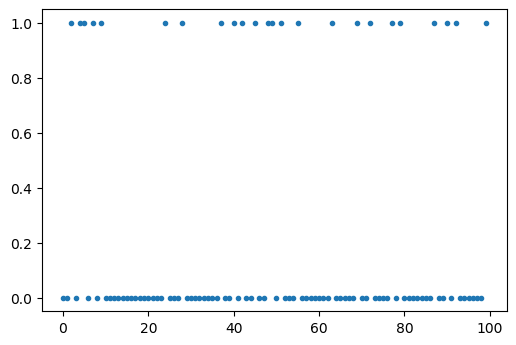

In [67]:
fig, ax = plt.subplots(dpi = 100)
ax.plot(experiment, marker = '.', linestyle = '')
fig.show()

Let us plot the prior pdf $\text{prob}(H | I)$:

(0, 1.1)

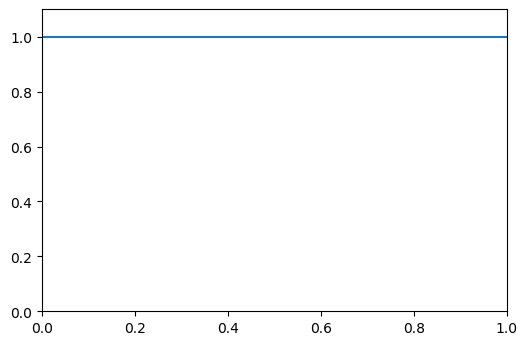

In [70]:
fig, ax = plt.subplots(dpi = 100)
ax.axhline(1)
ax.set_ylim(0, 1.1)

I think I know how to do this! First of all, for each event in the experiment you need to calculate the pdf (likelihood). By Bayes' theorem multiplying the prior (above picture) by the new pdf will approximate to the posterior pdf (what we are looking for). So, write a function that calculates the pdf at each step (remembering the previous one, maybe) and plots the resulting pdf (you can use some kde method to plot the pdf maybe). This is not so trivial at first glance, but it looks like a good challenge.